In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.holtwinters as ets
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error, roc_auc_score
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score


Pregunta 10

En el conjunto de datos de viviendas, la mediana de lat es:


In [71]:
df = pd.read_excel(r"C:\Users\Diego Olalla\Desktop\Datos\VentaViviendas.xlsx")
mediana_lat = df['lat'].median()
print(f"La mediana de lat es: {mediana_lat}")

La mediana de lat es: 47.5745


Pregunta 11

En el conjunto de datos de Viviendas, el número de valores únicos en condition es:

In [72]:
df['condition'].nunique()

5

Pregunta 12 

En el conjunto de datos de Viviendas, la cantidad de instancias que pertenecen a la
categoría 0 de la variable waterfront es:

In [73]:
conteo= df['waterfront'].value_counts()
conteo_0=df[df['waterfront']== 0].shape[0]
print("\nNúmero de instancias con waterfront = 0:", conteo_0)


Número de instancias con waterfront = 0: 4852


Pregunta 13

En el conjunto de datos de Viviendas, el porcentaje de filas faltantes no declaradas en la variable waterfront es:

In [74]:
conteo_missing= df[df['waterfront']== -1].shape[0]
total_filas= df.shape[0]
porcentaje_missing= (conteo_missing/ total_filas)*100
print(f"Porcentaje de filas faltantes no declaradas en waterfront: {porcentaje_missing:.2f}%")

Porcentaje de filas faltantes no declaradas en waterfront: 2.12%


Pregunta 14

En el conjunto de datos IPI (ventana de entrenamiento hasta el 31 de diciembre de
2017/ventana de prueba desde el 1 de enero de 2018), los resultados de la función
eval_model() para un modelo aditivo de Hot-Winters son:

Training data shape: (516, 4)
Test data shape: (23, 4)


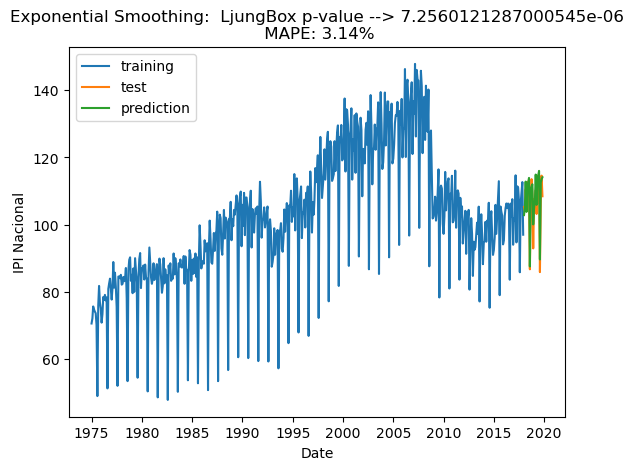

In [75]:
df_ipi=pd.read_excel(r"C:\Users\Diego Olalla\Desktop\Datos\IPI_Esp.xlsx")


df_ipi['Date'] = df_ipi['Date'].astype(str).str.strip()

df_ipi['Year'] = df_ipi['Date'].str.extract(r'(\d{4})')[0].astype(int)
df_ipi['Month'] = df_ipi['Date'].str.extract(r'M(\d{2})')[0].astype(int)
df_ipi['Date_clean'] = pd.to_datetime(df_ipi[['Year', 'Month']].assign(Day=1))

df_ipi.set_index('Date_clean', inplace=True)

train = df_ipi[:'2017-12-31']
test = df_ipi['2018-01-01':]

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")


def eval_model(model_fit, train_data, test_data, name='Model'):
    fitted_values = model_fit.fittedvalues
    tr_series = train['IPI Nacional']
    residuals = tr_series.iloc[-len(fitted_values):] - fitted_values
    lb_result = sm.stats.acorr_ljungbox(residuals, lags=12, return_df=True)
    lb = np.mean(lb_result.lb_pvalue)
    pred = model_fit.forecast(len(test))
    tst_series = test['IPI Nacional']
    fig1, ax = plt.subplots()
    ax.plot(tr_series, label='training')
    ax.plot(tst_series, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    mape = mean_absolute_percentage_error(tst_series, pred) * 100
    tit = f"{name}:  LjungBox p-value --> {lb}\n MAPE: {round(mape, 2)}%"
    plt.title(tit)
    plt.ylabel('IPI Nacional')
    plt.xlabel('Date')
    plt.show()
model = ExponentialSmoothing(
    train['IPI Nacional'],
    seasonal_periods=12,
    trend='add',
    seasonal='add',
    use_boxcox=False,
    initialization_method='estimated'
)
model_fit = model.fit()
eval_model(model_fit, train, test, name='Exponential Smoothing')

Pregunta 15

En el conjunto de datos IPI (ventana de entrenamiento hasta el 31 de diciembre de
2017/ventana de prueba desde el 1 de enero de 2018) los resultados de la función
eval_model() para un SARIMAX(1,1,1)(1,1,1)12 son:

Training data shape: (516, 4)
Test data shape: (23, 4)


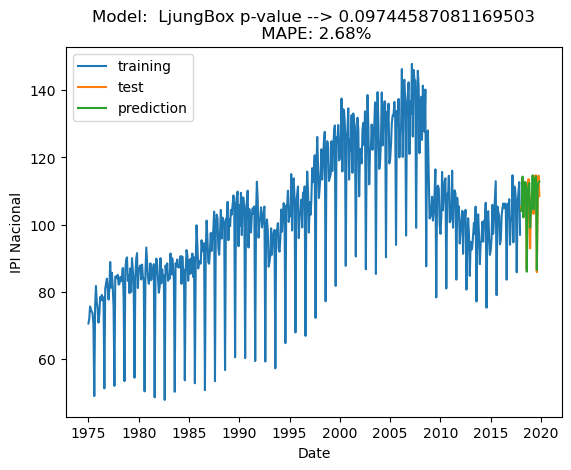

In [76]:
df_ipi['Date'] = df_ipi['Date'].astype(str).str.strip()

df_ipi['Year'] = df_ipi['Date'].str.extract(r'(\d{4})')[0].astype(int)
df_ipi['Month'] = df_ipi['Date'].str.extract(r'M(\d{2})')[0].astype(int)
df_ipi['Date_clean'] = pd.to_datetime(df_ipi[['Year', 'Month']].assign(Day=1))

df_ipi.set_index('Date_clean', inplace=True)

train_sarimax = df_ipi[:'2017-12-31']
test_sarimax = df_ipi['2018-01-01':]

print(f"Training data shape: {train_sarimax.shape}")
print(f"Test data shape: {test_sarimax.shape}")

def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.predict(start=tst.index[0], end=tst.index[-1])
    tr_series = tr['IPI Nacional']
    tst_series = tst['IPI Nacional']
    fig1, ax = plt.subplots()
    ax.plot(tr_series, label='training')
    ax.plot(tst_series, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    mape = mean_absolute_percentage_error(tst_series, pred) * 100
    tit = f"{name}:  LjungBox p-value --> {lb}\n MAPE: {round(mape, 2)}%"
    plt.title(tit)
    plt.ylabel('IPI Nacional')
    plt.xlabel('Date')
    plt.show()
arima1 = SARIMAX(train_sarimax['IPI Nacional'],
                order = (1, 1, 1),
                seasonal_order =(1, 1, 1, 12))

arima_1 = arima1.fit()
arima_1.summary()

eval_model_Aarima(arima_1, train_sarimax, test_sarimax)

Pregunta 16

En el conjunto de datos de Viviendas, la cantidad de instancias con valor cero en
yr_renovated es:

In [77]:
count_zero = (df['yr_renovated'] == 0).sum()
print(f"Cantidad de instancias con valor cero en yr_renovated: {count_zero}")

Cantidad de instancias con valor cero en yr_renovated: 4784


Pregunta 17

En el conjunto de datos de Viviendas (sin limpieza) el valor R^2 de un modelo con
fórmula 'precio ~ lat' es:

In [78]:
X_lat= sm.add_constant(df['lat'])
y_precio= df['price']

model= sm.OLS(y_precio, X_lat).fit()
print(f"R^2 del modelo 'precio ~ lat': {model.rsquared:.3f}")

R^2 del modelo 'precio ~ lat': 0.091


Pregunta 18

En el conjunto de datos de Viviendas, la media de sqft_living es:

In [79]:
media_sqft_living= df['sqft_living'].mean()
print(f"Media de sqft_living: {media_sqft_living}")

Media de sqft_living: 2077.382


Pregunta 19

En el conjunto de datos de Viviendas, la desviación típica de price es:

In [80]:
std_price= df['price'].std()
print(f"Desviación típica de price: {std_price}")
print(f"Desviación típica de price (redondeada a 1 decimal): {std_price:.1f}")

Desviación típica de price: 372986.94061845745
Desviación típica de price (redondeada a 1 decimal): 372986.9


Pregunta 20

En el conjunto de datos de Viviendas, el número de valores únicos de bedrooms es:

In [81]:
unique_bedrooms= df['bedrooms'].unique()
num_unique_bedrooms= len(unique_bedrooms)
print(f"El número de valores únicos de bedrooms es: {num_unique_bedrooms}")

El número de valores únicos de bedrooms es: 33


Pregunta 21

En el conjunto de datos de Viviendas, el porcentaje de missings sin declarar en sqft_lot
es:

In [82]:
negative_count= (df['sqft_lot'] <0).sum()
total_rows=len(df)
percentage_missing_lot= (negative_count/total_rows)* 100
print(f"Porcentaje de missings sin declarar en sqft_lot: {percentage_missing_lot:.2f}%")

Porcentaje de missings sin declarar en sqft_lot: 7.64%


Pregunta 22

En el conjunto de datos de viviendas (sin limpieza) el parámetro estimado para el
predictor en el modelo con la fórmula ‘price ~ sqft_living' es:

In [83]:
X_vivienda= sm.add_constant(df['sqft_living'])
y_vivienda= df['price']
model= sm.OLS(y_vivienda,X_vivienda).fit()
coef_sqft_living= model.params[1]
print(f"Parámetro estimado para sqft_living (redondeado a 4 decimales): {coef_sqft_living:.4f}")

Parámetro estimado para sqft_living (redondeado a 4 decimales): 291.3188


Pregunta 23

En el conjunto de datos de viviendas (sin limpieza) el Odds Ratio estimado para el
predictor en el modelo con la fórmula 'Luxury ~ sqft_living' es:

In [84]:
X_vivienda_odds= sm.add_constant(df['sqft_living'])
y_vivienda_odds= df['Luxury']
model= sm.Logit(y_vivienda_odds, X_vivienda_odds).fit()
coef_sqft_living= model.params[1]
odds_ratio= np.exp(coef_sqft_living)
print(f"Odds Ratio para sqft_living (redondeado a 6 decimales): {odds_ratio:.6f}")

Optimization terminated successfully.
         Current function value: 0.500003
         Iterations 6
Odds Ratio para sqft_living (redondeado a 6 decimales): 1.001866


Pregunta 24

En el conjunto de datos IPI (ventana de entrenamiento hasta 2017-12-31/ventana de
prueba desde 2018-01-01), los resultados de eval_model() para un modelo
SARIMAX(1,1,0)(1,1,0)12 son:

Training data shape: (516, 4)
Test data shape: (23, 4)


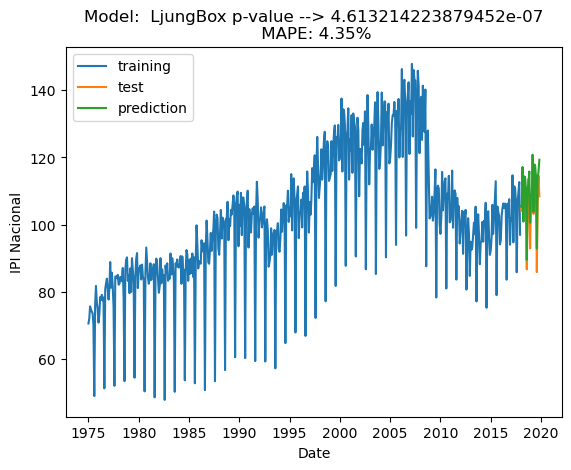

In [85]:
df_ipi['Date'] = df_ipi['Date'].astype(str).str.strip()
df_ipi['Year'] = df_ipi['Date'].str.extract(r'(\d{4})')[0].astype(int)
df_ipi['Month'] = df_ipi['Date'].str.extract(r'M(\d{2})')[0].astype(int)
df_ipi['Date_clean'] = pd.to_datetime(df_ipi[['Year', 'Month']].assign(Day=1))
df_ipi.set_index('Date_clean', inplace=True)

train_sarimax = df_ipi[:'2017-12-31']
test_sarimax = df_ipi['2018-01-01':]

print(f"Training data shape: {train_sarimax.shape}")
print(f"Test data shape: {test_sarimax.shape}")

def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.predict(start=tst.index[0], end=tst.index[-1])
    tr_series = tr['IPI Nacional']
    tst_series = tst['IPI Nacional']
    fig1, ax = plt.subplots()
    ax.plot(tr_series, label='training')
    ax.plot(tst_series, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    mape = mean_absolute_percentage_error(tst_series, pred) * 100
    tit = f"{name}:  LjungBox p-value --> {lb}\n MAPE: {round(mape, 2)}%"
    plt.title(tit)
    plt.ylabel('IPI Nacional')
    plt.xlabel('Date')
    plt.show()
arima1 = SARIMAX(train_sarimax['IPI Nacional'],
                order = (1, 1, 0),
                seasonal_order =(1, 1, 0, 12))

arima_1 = arima1.fit()
arima_1.summary()

eval_model_Aarima(arima_1, train_sarimax, test_sarimax)

Pregunta Opcional 1

En el archivo Fuga de Clientes, imputa los valores perdidos de las variables numéricas
por la mediana y los valores pedidos de las variables categóricas por la moda,
obteniendo un nuevo archivo fuga_meadian_moda.
Con este archivo imputado, ajusta el modelo de fórmula ‘Fuga ~ MetodoPago +
Contrato + Antigüedad*FacturaMes’ mediante la función logit de statsmodels.
¿Cuáles son los valores de PseudoR2 de McFadden y del logaritmo de la verosimilitud
del modelo? ¿Cuántos parámetros estima el modelo? ¿Cuántos resultan significativosal
95% de nivel de confianza?

In [86]:
df_fuga = pd.read_csv(r"C:\Users\Diego Olalla\Desktop\Datos\FugaClientes.csv")

numeric_cols = ['Mayor65', 'Antig.fc.edad', 'FacturaMes', 'FacturaTotal']
categorical_cols = [col for col in df_fuga.columns if col not in numeric_cols and col != 'Fuga' and col != 'ID']

for col in numeric_cols:
    if df_fuga[col].isnull().sum() > 0:
        median_value = df_fuga[col].median()
        df_fuga[col] = df_fuga[col].fillna(median_value)
        print(f"Imputado {col} con mediana: {median_value}")

for col in categorical_cols:
    if df_fuga[col].isnull().sum() > 0:
        mode_value = df_fuga[col].mode()[0]
        df_fuga[col] = df_fuga[col].fillna(mode_value)
        print(f"Imputado {col} con moda: {mode_value}")

df_fuga.to_csv('fuga_median_moda.csv', index=False)
print("Archivo 'fuga_median_moda.csv' creado correctamente")

df_fuga = df_fuga.rename(columns={'Antig.fc.edad': 'Antiguedad'})

formula = 'Fuga ~ MetodoPago + Contrato + Antiguedad*FacturaMes'
model = smf.logit(formula=formula, data=df_fuga).fit()

print("\nResumen del modelo:")
print(model.summary())

print("\nMétricas solicitadas:")
print(f"PseudoR2 de McFadden: {model.prsquared:.4f}")
print(f"Logaritmo de la verosimilitud: {model.llf:.1f}")
print(f"Número de parámetros estimados: {len(model.params)}")

pvalues = model.pvalues
significant_params = sum(pvalues < 0.05)
print(f"Número de parámetros significativos al 95%: {significant_params}")

Imputado Mayor65 con mediana: 0.0
Imputado Antig.fc.edad con mediana: 29.0
Imputado FacturaMes con mediana: 70.3
Imputado FacturaTotal con mediana: 1384.175
Imputado Genero con moda: Male
Imputado Telf_serv con moda: Yes
Imputado Int_serv con moda: Fiber optic
Imputado Contrato con moda: Month-to-month
Imputado Fact_sinPapel con moda: Yes
Imputado MetodoPago con moda: Electronic check
Archivo 'fuga_median_moda.csv' creado correctamente
Optimization terminated successfully.
         Current function value: 0.434927
         Iterations 8

Resumen del modelo:
                           Logit Regression Results                           
Dep. Variable:                   Fuga   No. Observations:                 6353
Model:                          Logit   Df Residuals:                     6344
Method:                           MLE   Df Model:                            8
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.2483
Time:                        13:41:02   Lo

Pregunta Opcional 2

Con el mismo archivo imputado anteriormente, ajusta un proceso de selección
automática de variables secuencial (SFS) con el método backward, y la configuración
por parsimonia. La métrica ha de ser ‘roc_auc’, floating=F y 5 folders para la validación
cruzada.
Nota: Tendrás que obtener la matriz explícita de diseño del modelo completo (sin el
identificador de filas, claro!) y para ello puedes utilizar la función pasty.dmatrices.
Una vez finalizado el proceso, ¿Cuántos parámetros propone el método (directo de la
salida)? ¿Cuál es el valor del área bajo la curva Roc resultante?

In [87]:
df_fuga = pd.read_csv(r"C:\Users\Diego Olalla\Desktop\Datos\FugaClientes.csv")
numeric_cols = ['Mayor65', 'Antig.fc.edad', 'FacturaMes', 'FacturaTotal']
categorical_cols = [col for col in df_fuga.columns if col not in numeric_cols and col != 'Fuga' and col != 'ID']
for col in numeric_cols:
    if df_fuga[col].isnull().sum() > 0:
        median_value = df_fuga[col].median()
        df_fuga[col] = df_fuga[col].fillna(median_value)
        print(f"Imputado {col} con mediana: {median_value}")

for col in categorical_cols:
    if df_fuga[col].isnull().sum() > 0:
        mode_value = df_fuga[col].mode()[0]
        df_fuga[col] = df_fuga[col].fillna(mode_value)
        print(f"Imputado {col} con moda: {mode_value}")
df_fuga = df_fuga.rename(columns={'Antig.fc.edad': 'Antiguedad'})
formula = 'Fuga ~ ' + ' + '.join([col for col in df_fuga.columns if col not in ['ID', 'Fuga']])
y, X = patsy.dmatrices(formula, df_fuga, return_type='dataframe')
y = y.values.ravel()

def backward_selection(X, y, scoring='roc_auc', cv=5):
    features = list(X.columns)
    n_features = len(features)
    model = LogisticRegression(max_iter=1000, random_state=42)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    X_selected = X[features]
    base_score = np.mean(cross_val_score(model, X_selected, y, cv=cv_split, scoring=scoring))
    print(f"Puntuación inicial con {n_features} características: {base_score:.4f}")
    results = {n_features: {'score': base_score, 'features': features.copy()}}
    current_features = features.copy()
    current_score = base_score
    
    for i in range(n_features - 1, 0, -1):
        best_score = 0
        worst_feature = None
        for feature in current_features:
            temp_features = [f for f in current_features if f != feature]
            X_temp = X[temp_features]
            score = np.mean(cross_val_score(model, X_temp, y, cv=cv_split, scoring=scoring))
            if score > best_score:
                best_score = score
                worst_feature = feature
        if worst_feature:

            current_features.remove(worst_feature)
            current_score = best_score
            results[i] = {'score': current_score, 'features': current_features.copy()}
            
            print(f"Eliminada característica: {worst_feature}, Nuevas características: {len(current_features)}, Score: {current_score:.4f}")
        else:
            break
    best_score = max([results[k]['score'] for k in results])
    threshold = best_score * 0.99  # 99% del mejor rendimiento
    
    for k in sorted(results.keys()):
        if results[k]['score'] >= threshold:
            parsimonious_model = k
            break
    
    return results, parsimonious_model

print("Iniciando selección backward...")
results, parsimonious_k = backward_selection(X, y, scoring='roc_auc', cv=5)

print("\nModelo parsimonioso:")
print(f"Número de parámetros: {parsimonious_k}")
print(f"Características seleccionadas: {results[parsimonious_k]['features']}")
print(f"Área bajo la curva ROC: {results[parsimonious_k]['score']:.4f}")

print("\nResumen de todos los modelos:")
for k in sorted(results.keys()):
    print(f"Características: {k}, ROC AUC: {results[k]['score']:.4f}")

Imputado Mayor65 con mediana: 0.0
Imputado Antig.fc.edad con mediana: 29.0
Imputado FacturaMes con mediana: 70.3
Imputado FacturaTotal con mediana: 1384.175
Imputado Genero con moda: Male
Imputado Telf_serv con moda: Yes
Imputado Int_serv con moda: Fiber optic
Imputado Contrato con moda: Month-to-month
Imputado Fact_sinPapel con moda: Yes
Imputado MetodoPago con moda: Electronic check
Iniciando selección backward...
Puntuación inicial con 24 características: 0.8431
Eliminada característica: FacturaTotal, Nuevas características: 23, Score: 0.8436
Eliminada característica: Antivirus_disp[T.Yes], Nuevas características: 22, Score: 0.8440
Eliminada característica: MetodoPago[T.Mailed check], Nuevas características: 21, Score: 0.8442
Eliminada característica: Conyuge[T.Yes], Nuevas características: 20, Score: 0.8443
Eliminada característica: Genero[T.Male], Nuevas características: 19, Score: 0.8443
Eliminada característica: Intercept, Nuevas características: 18, Score: 0.8443
Eliminada cara

Pregunta Opcional 3

En el archivo clientes_cluster.csv, elimina los valores perdidos por lista. ¿Cuántos
registros válidos quedan? Recodifica la variable Gender como una dummy (asegura que
poner el drop_first=True) y elimina CustomerID. Escala el archivo. Ajusta un modelo
de Kmeans con 4 grupos 25 inicializaciones de centroides y semilla 2025.
¿Cuál es el valor de la varianza interna de esta solución de clustering? ¿Y el valor de la
silueta? ¿Qué valor tiene el centroide para el primer grupo y primera variable? ¿Y para
la última variable en el último grupo?

In [88]:
df_clientes = pd.read_csv(r"C:\Users\Diego Olalla\Desktop\Datos\clientes_cluster.csv")

print(f"Forma inicial: {df_clientes.shape}")

print("\nValores faltantes por columna:")
print(df_clientes.isnull().sum())

df_limpio = df_clientes.dropna()
print(f"\nForma después de eliminar valores faltantes: {df_limpio.shape}")
print(f"Número de registros válidos: {len(df_limpio)}")

df_limpio = pd.get_dummies(df_limpio, columns=['Gender'], drop_first=True)

df_limpio = df_limpio.drop('CustomerID', axis=1)

print("\nColumnas después de la transformación:")
print(df_limpio.columns.tolist())

escalador = StandardScaler()
df_escalado = pd.DataFrame(escalador.fit_transform(df_limpio), columns=df_limpio.columns)

kmeans = KMeans(n_clusters=4, n_init=25, random_state=2025)
clusters = kmeans.fit_predict(df_escalado)

inercia = kmeans.inertia_
print(f"\nInercia: {inercia:.3f}")

silueta = silhouette_score(df_escalado, clusters)
print(f"Puntuación de silueta: {silueta:.3f}")

centroides = kmeans.cluster_centers_
print("\nCentroides:")
print(centroides)

centroide_1_1 = centroides[0, 0]
print(f"\nCentroide 1,1: {centroide_1_1:.3f}")

centroide_4_4 = centroides[3, -1]
print(f"Centroide 4,4: {centroide_4_4:.3f}")

Forma inicial: (200, 5)

Valores faltantes por columna:
CustomerID                 0
Gender                    15
Age                       13
Annual Income (k$)         9
Spending Score (1-100)    18
dtype: int64

Forma después de eliminar valores faltantes: (150, 5)
Número de registros válidos: 150

Columnas después de la transformación:
['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']

Inercia: 287.502
Puntuación de silueta: 0.301

Centroides:
[[-0.73506864  0.06817683  0.68278019 -0.89845919]
 [ 0.79162791 -0.07951157 -0.77321513  1.11301661]
 [ 0.64364721 -0.06242197 -0.63063049 -0.89845919]
 [-0.81190816  0.08562427  0.83963854  1.11301661]]

Centroide 1,1: -0.735
Centroide 4,4: 1.113


Pregunta Opcional 4

Reduce las dimensiones del archivo anterior (escalado y sin perdidos) a 2 componentes
principales. Obtén los resultados y dibuja el biplot. ¿Cuál es el valor de la carga de la
variable ’Age’ en la componente 1? ¿Qué variable tiene la mayor proyección sobre la
componente 2?

Forma inicial: (200, 5)

Valores faltantes por columna:
CustomerID                 0
Gender                    15
Age                       13
Annual Income (k$)         9
Spending Score (1-100)    18
dtype: int64

Forma después de eliminar valores faltantes: (150, 5)

Columnas después de la transformación:
['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']

Matriz de cargas (loadings):
                             PC1       PC2
Age                     0.662767  0.043028
Annual Income (k$)     -0.315729  0.159463
Spending Score (1-100) -0.677432  0.035084
Gender_Male             0.046261  0.985641

Carga de 'Age' en la componente 1: 0.662767
Variable con mayor proyección en la componente 2: Gender_Male con valor 0.985641

Varianza explicada por cada componente:
PC1: 0.3434 (34.34%)
PC2: 0.2502 (25.02%)
Total: 0.5936 (59.36%)


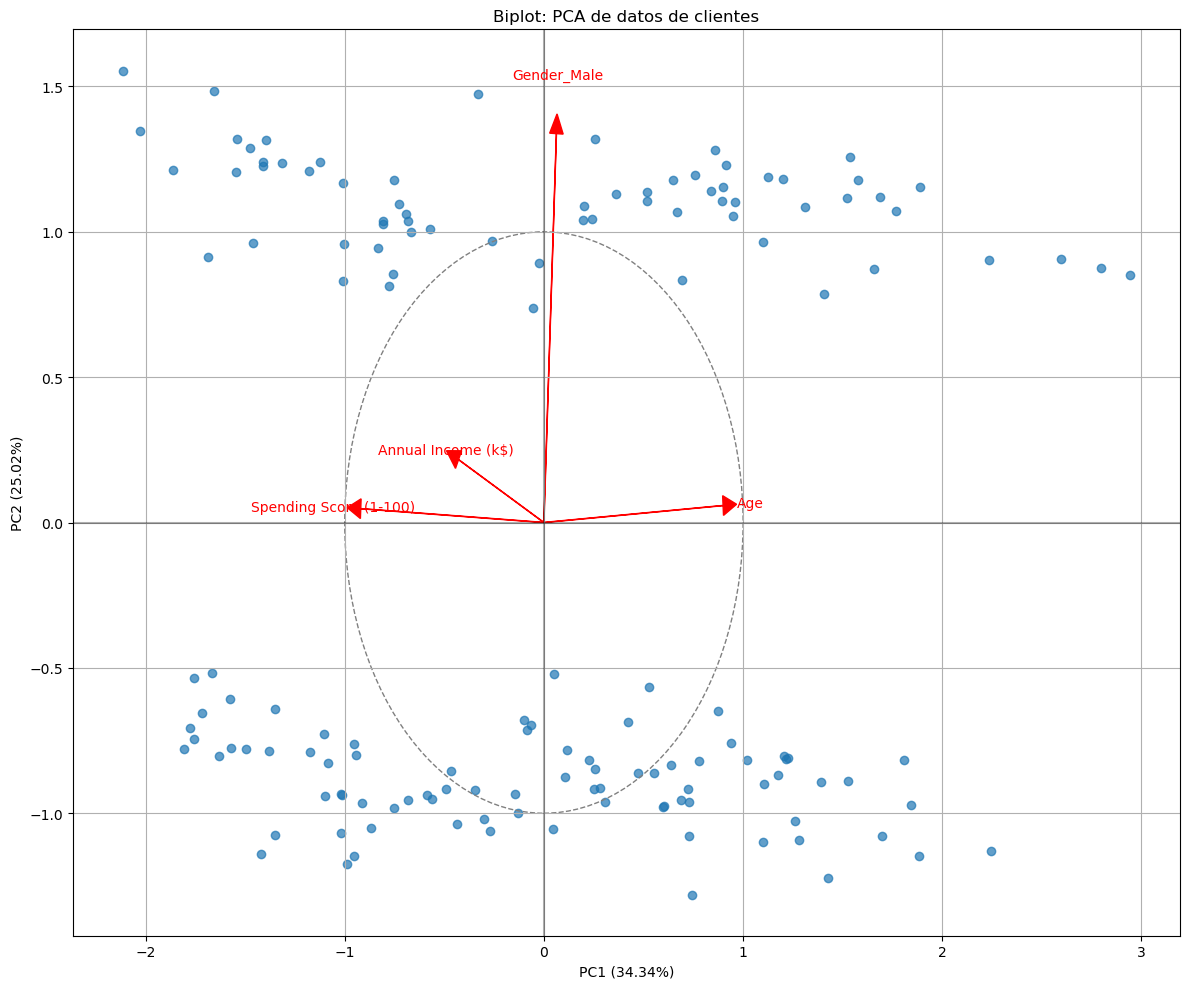

In [89]:
print(f"Forma inicial: {df_clientes.shape}")
print("\nValores faltantes por columna:")
print(df_clientes.isnull().sum())

df_limpio = df_clientes.dropna()
print(f"\nForma después de eliminar valores faltantes: {df_limpio.shape}")

df_limpio = pd.get_dummies(df_limpio, columns=['Gender'], drop_first=True)

df_limpio = df_limpio.drop('CustomerID', axis=1)

print("\nColumnas después de la transformación:")
print(df_limpio.columns.tolist())

escalador = StandardScaler()
df_escalado = pd.DataFrame(escalador.fit_transform(df_limpio), columns=df_limpio.columns)

pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(df_escalado)

df_pca = pd.DataFrame(data=componentes_principales, columns=['PC1', 'PC2'])

loadings = pca.components_.T
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_escalado.columns)

print("\nMatriz de cargas (loadings):")
print(loading_matrix)

print(f"\nCarga de 'Age' en la componente 1: {loading_matrix.loc['Age', 'PC1']:.6f}")

max_loading_pc2 = loading_matrix['PC2'].abs().idxmax()
print(f"Variable con mayor proyección en la componente 2: {max_loading_pc2} con valor {loading_matrix.loc[max_loading_pc2, 'PC2']:.6f}")

print(f"\nVarianza explicada por cada componente:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Total: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

plt.figure(figsize=(12, 10))

plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1], alpha=0.7)

scaling = np.min([np.abs(plt.xlim()).max(), np.abs(plt.ylim()).max()]) * 0.8
n = loading_matrix.shape[0]
for i in range(n):
    plt.arrow(0, 0, 
              loading_matrix.iloc[i, 0] * scaling, 
              loading_matrix.iloc[i, 1] * scaling,
              head_width=0.05*scaling, head_length=0.05*scaling, 
              fc='red', ec='red')
    plt.text(loading_matrix.iloc[i, 0] * scaling * 1.15, 
             loading_matrix.iloc[i, 1] * scaling * 1.15, 
             loading_matrix.index[i], 
             color='red', ha='center', va='center')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Biplot: PCA de datos de clientes')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

circle = plt.Circle((0,0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_patch(circle)

plt.tight_layout()
plt.savefig('biplot_clientes_mejorado.png', dpi=300)
plt.show()